In [2]:
# Import packages

import pandas as pd 
import numpy as np 
import os

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

import xgboost as xgb

from joblib import dump, load

pd.set_option('display.max_columns', None)

C:\Users\imacd_0odruq3\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
base = pd.read_csv('../data/past_6_game_stats_modeling_base_df.csv')
model = load('../modeling/game_outcome_modeling/saved_models/logistic_regression.joblib')
feature_list = ['qb_value_home', 'rushing_value_home', 'qb_def_value_home', 'rush_def_value_home', 'special_teams_value_home',
                   'qb_value_away', 'rushing_value_away', 'qb_def_value_away', 'rush_def_value_away', 'special_teams_value_away']

In [4]:
# Get predictions and probabilites

base = base.dropna()
features = base[feature_list].to_numpy()

# Get win predictions/probabilities

win_preds = model.predict(features)
win_probs = model.predict_proba(features)

In [5]:
base['home_win_pred'] = win_preds
base['home_win_prob'] = win_probs[:,1]
base['away_win_prob'] = win_probs[:,0]

In [6]:
# Set what part of the data to analyze
# Most models will just look at the test set (2022 for now)
# For models with very low overfitting, could be fruitful to look at the results on the entire data set though

analysis_df = base[base.season == 2022]
analysis_df['pred_correct'] = analysis_df.apply(lambda x: 1 if x.home_win == x.home_win_pred else 0, axis=1)
analysis_df.head()

<ipython-input-6-46d6637f0077>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis_df['pred_correct'] = analysis_df.apply(lambda x: 1 if x.home_win == x.home_win_pred else 0, axis=1)


,Unnamed: 0,date,season,week,season_type,home,away,home_score,away_score,home_qb,away_qb,qb_value_home,passing_value_home,rushing_value_home,qb_rushing_value_pct_home,qb_def_value_home,pass_def_value_home,rush_def_value_home,special_teams_value_home,qb_value_away,passing_value_away,rushing_value_away,qb_rushing_value_pct_away,qb_def_value_away,pass_def_value_away,rush_def_value_away,special_teams_value_away,home_win,home_win_pred,home_win_prob,away_win_prob,pred_correct
2161,2170,2022-09-15,2022,2,REG,Kansas City Chiefs,Los Angeles Chargers,27,24,Patrick Mahomes,Justin Herbert,2.777998,2.604258,-0.000350,0.0,0.069608,0.192568,-0.502682,-0.235838,1.031707,1.299644,-1.618057,0.0,0.860568,0.750229,-0.073749,-1.246572,1,1,0.787751,0.212249,1
2162,2171,2022-09-18,2022,2,REG,Baltimore Ravens,Miami Dolphins,38,42,Lamar Jackson,Tua Tagovailoa,0.427739,0.298861,-0.072916,0.0,0.954686,1.168481,0.558912,1.483946,0.329009,0.450016,-0.485157,0.0,0.692146,0.853199,0.679969,0.370524,0,1,0.670334,0.329666,0
2163,2172,2022-09-18,2022,2,REG,Pittsburgh Steelers,New England Patriots,14,17,Mitch Trubisky,Mac Jones,-0.609634,-0.613912,-0.238262,0.0,1.508322,1.552132,0.663480,-0.568998,-0.714310,-0.885816,-0.679969,0.0,-0.322972,-0.444596,0.485157,-0.370524,0,1,0.727787,0.272213,0
2164,2173,2022-09-18,2022,2,REG,Jacksonville Jaguars,Indianapolis Colts,24,0,Trevor Lawrence,Matt Ryan,-0.318082,-0.174636,1.011675,0.0,-0.602612,-0.698344,0.817515,0.053898,-0.343247,0.183405,-0.523992,0.0,0.719603,0.674593,0.805541,-0.804267,1,1,0.643090,0.356910,1
2165,2174,2022-09-18,2022,2,REG,New York Giants,Carolina Panthers,19,16,Daniel Jones,Baker Mayfield,-0.874421,-0.736282,1.705533,0.0,-0.611447,-0.605268,0.928781,0.891777,-0.301415,-0.248869,0.650743,0.0,0.719348,0.753120,-1.795863,-0.400349,1,1,0.592666,0.407334,1


In [7]:
# Get general accuracy measurements

accuracy = accuracy_score(analysis_df.home_win, analysis_df.home_win_pred)
tn, fp, fn, tp = confusion_matrix(analysis_df.home_win, analysis_df.home_win_pred).ravel()
precision = tp/(tp+fp)
recall = tp/(tp+fn)

print('Accuracy: {}'.format(accuracy))
print('Precision: {}'.format(precision))
print('Recall: {}'.format(recall))
print()
print('True Positive Rate: {}'.format(tp/(tp+fn)))
print('False Positive Rate: {}'.format(fp/(fp+tn)))
print('True Negative Rate: {}'.format(tn/(tn+fp)))
print('False Negative Rate: {}'.format(fn/(fn+tp)))

Accuracy: 0.6008583690987125
Precision: 0.6351351351351351
Recall: 0.706766917293233

True Positive Rate: 0.706766917293233
False Positive Rate: 0.54
True Negative Rate: 0.46
False Negative Rate: 0.2932330827067669


In [8]:
# Get NFL translated accuracy stats

home_win_pct = sum(analysis_df.home_win==1)/len(analysis_df)
away_win_pct = sum(analysis_df.home_win==0)/len(analysis_df)

home_win_pred_pct = sum(analysis_df.home_win_pred==1)/len(analysis_df)
away_win_pred_pct = sum(analysis_df.home_win_pred==0)/len(analysis_df)

print('Home Win Percentage: {}'.format(home_win_pct))
print('Away Win Percentage: {}'.format(away_win_pct))
print('Home Win Predicted Percentage: {}'.format(home_win_pred_pct))
print('Away Win Predicted Percentage: {}'.format(away_win_pred_pct))

Home Win Percentage: 0.5708154506437768
Away Win Percentage: 0.4291845493562232
Home Win Predicted Percentage: 0.6351931330472103
Away Win Predicted Percentage: 0.3648068669527897


In [9]:
home_wins = analysis_df[analysis_df.home_win==1]
away_wins = analysis_df[analysis_df.home_win==0]

home_win_acc = accuracy_score(home_wins.home_win, home_wins.home_win_pred)
away_win_acc = accuracy_score(away_wins.home_win, away_wins.home_win_pred)

home_wins_pred = analysis_df[analysis_df.home_win_pred==1]
away_wins_pred = analysis_df[analysis_df.home_win_pred==0]

home_win_pred_acc = accuracy_score(home_wins_pred.home_win, home_wins_pred.home_win_pred)
away_win_pred_acc = accuracy_score(away_wins_pred.home_win, away_wins_pred.home_win_pred)

print('Accuracy for Home Wins: {}'.format(home_win_acc))
print('Accuracy for Away Wins: {}'.format(away_win_acc))
print()
print('Accuracy for Home Wins Predicted: {}'.format(home_win_pred_acc))
print('Accuracy for Away Wins Predicted: {}'.format(away_win_pred_acc))

Accuracy for Home Wins: 0.706766917293233
Accuracy for Away Wins: 0.46

Accuracy for Home Wins Predicted: 0.6351351351351351
Accuracy for Away Wins Predicted: 0.5411764705882353


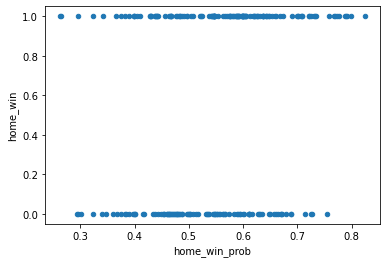

In [10]:
# Plot home win probability vs result

analysis_df.plot.scatter(x='home_win_prob', y='home_win')

      correct_preds  total_games  accuracy
week                                      
2                 7           15  0.466667
3                 6           16  0.375000
4                 7           13  0.538462
5                 8           15  0.533333
6                 6           13  0.461538
7                 6           11  0.545455
8                 9           13  0.692308
9                 7           11  0.636364
10                5           13  0.384615
11               12           14  0.857143
12                5           12  0.416667
13                6           11  0.545455
14                7           10  0.700000
15               11           15  0.733333
16                9           14  0.642857
17                9           13  0.692308
18               11           12  0.916667
19                5            6  0.833333
20                3            4  0.750000
21                1            1  1.000000
22                0            1  0.000000


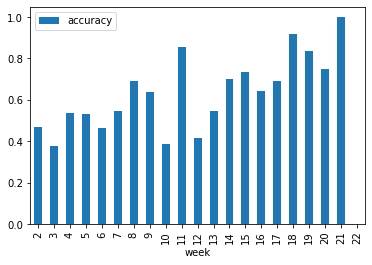

In [36]:
# Week by week accuracy

weekly = analysis_df.groupby(by='week').agg(correct_preds=('pred_correct', 'sum'), total_games=('pred_correct', 'count'))
weekly['accuracy'] = weekly.correct_preds/weekly.total_games
print(weekly)
weekly.plot.bar(y='accuracy')

In [35]:
# Average Confidence
# When correctly predicting a win, how confident were we in the prediction on average?
# Likewise, when incorrect, how confident were we?

pred_confs = analysis_df.groupby(by=['pred_correct', 'home_win']).mean()[['home_win_prob', 'away_win_prob']]
pred_confs

home_win_prob  away_win_prob
pred_correct home_win                              
0            0              0.600600       0.399400
             1              0.424065       0.575935
1            0              0.428111       0.571889
             1              0.629262       0.370738

In [ ]:
# Bring in the gambling data, see how we would have fared with actual betting
# Also, compare accuracy for favorites, underdogs, etc.